In [7]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/raw/data.csv").drop_duplicates()
df = df.dropna(subset=["Age","Month","City","Time","Total_Purchases","Product_Category","Amount"])

# Feature engineering
df['Month'] = pd.to_datetime(df['Date']).dt.month
df['Hour'] = pd.to_datetime(df['Time']).dt.hour

# Target: log-transform
y = np.log1p(df['Amount'])


/var/folders/vf/rbbd31d52x71bpbg3sn62p3r0000gn/T/ipykernel_11232/3895309516.py:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Hour'] = pd.to_datetime(df['Time']).dt.hour


In [8]:
from sklearn.preprocessing import StandardScaler

# Numeric features
num_feat = df[['Age','Total_Purchases','Month','Hour']]

# Categorical features one-hot
cat_feat = pd.get_dummies(df[['City','Product_Category']], drop_first=True)

# Combine
X = pd.concat([num_feat, cat_feat], axis=1)

# Normalize numeric features only
scaler = StandardScaler()
X[num_feat.columns] = scaler.fit_transform(X[num_feat.columns])


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [10]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)
model.fit(X_train, y_train)


,n_estimators,500
,criterion,'squared_error'
,max_depth,15
,min_samples_split,5
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
from sklearn.metrics import r2_score, mean_squared_error

y_pred = model.predict(X_test)
print("R2 Score (log scale):", r2_score(y_test, y_pred))
print("RMSE (log scale):", np.sqrt(mean_squared_error(y_test, y_pred)))

# Back-transform to original scale
y_pred_orig = np.expm1(y_pred)
y_test_orig = np.expm1(y_test)
print("R2 Score (original scale):", r2_score(y_test_orig, y_pred_orig))


R2 Score (log scale): -4.982761295835303e-05
RMSE (log scale): 0.8165512225015907
R2 Score (original scale): -0.15343329839722197


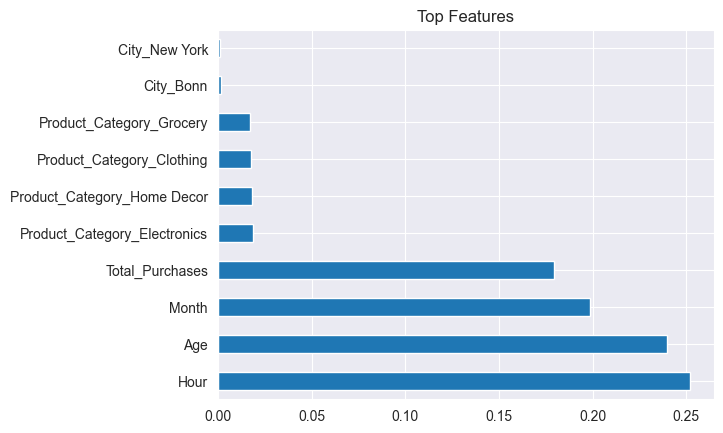

In [12]:
import matplotlib.pyplot as plt

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)
importances[:10].plot(kind='barh', title='Top Features')
plt.show()
